In [68]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.offline import plot, iplot, init_notebook_mode, download_plotlyjs
import cufflinks as cf
from cufflinks.offline import go_offline

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

In [4]:
init_notebook_mode(connected=True)
cf.go_offline()

In [5]:
# Handle warnings
import warnings
from warnings import filterwarnings
filterwarnings("ignore")

DATA COLLECTING

In [6]:
# Import dataset
data = pd.read_excel(r"/Users/jmc/GitHub/PredictAirplaneFare/predict-fares-ariplanes-ticket/dataset/dataset.xlsx")

DATA CLEANING

In [7]:
data.shape

(10683, 11)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


As we can see, almost all variables have object Dtype.
We'll have to address this with some preprocessing since ML works so much better with numerical features.

In [9]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Handling missing values

In [10]:
data[data['Route'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


Since there is only one row with missing values, I'll delete this row. the impact is going to be minimum to the dataset.

In [11]:
data.dropna(inplace=True)

Data Preprocessing

In [12]:
df = data.copy()

In [13]:
def change_into_datetime(col):
    df[col] = pd.to_datetime(data[col])

In [14]:
for feature in ['Date_of_Journey', 'Arrival_Time','Dep_Time']:
    change_into_datetime(feature)

In [15]:
# Extract day, month, year of journey
df['Journey_Day'] = df['Date_of_Journey'].dt.day
df['Journey_Month'] = df['Date_of_Journey'].dt.month
df['Journey_Year'] = df['Date_of_Journey'].dt.year

In [16]:
def extract_hour_min(df, col):
    df[col+"_hour"] = df[col].dt.hour
    df[col+"_minute"] = df[col].dt.minute

In [17]:
extract_hour_min(df,'Arrival_Time')
extract_hour_min(df, 'Dep_Time')

In [18]:
col_to_drop = ['Arrival_Time', 'Dep_Time', 'Date_of_Journey']

In [19]:
df.drop(col_to_drop, axis=1, inplace=True)

In [20]:
# Convert Duration (Object) into a numerical feature

def preprocess_duration(duration):
    if 'h' not in duration:
        duration = '0h' + ' ' + duration
    elif 'm' not in duration:
        duration = duration + ' ' + '0m'
    
    return duration

In [21]:
df["Duration"] = df["Duration"].apply(preprocess_duration)

In [22]:
df['Duration_Hours'] = df['Duration'].apply(lambda x : int(x.split(' ')[0][0:-1]))
df['Duration_Minutes'] = df['Duration'].apply(lambda x : int(x.split(' ')[1][0:-1]))

In [23]:
df.drop("Duration",axis=1,inplace=True)

Data Analysis

In [24]:
def flight_dep_time(hour):
    if (hour > 4) and (hour <= 8):
        return "Early Morning"
    elif (hour > 8) and (hour <= 12):
        return "Morning"
    elif (hour > 12) and (hour <= 16):
        return "Afternoon"
    elif (hour > 16) and (hour <= 20):
        return "Evening"
    elif (hour > 20) and (hour <= 24):
        return "Night"
    else:
        return "Late Night"

In [25]:
#df["Dep_Time_hour"].apply(flight_dep_time).value_counts().plot(kind="bar")

In [26]:
df["Dep_Time_hour"].apply(flight_dep_time).value_counts().iplot(kind="bar",color='blue')

In [27]:
df['Total_Duration_mins'] = df['Duration_Hours']*60+df['Duration_Minutes']

<Axes: xlabel='Total_Duration_mins', ylabel='Price'>

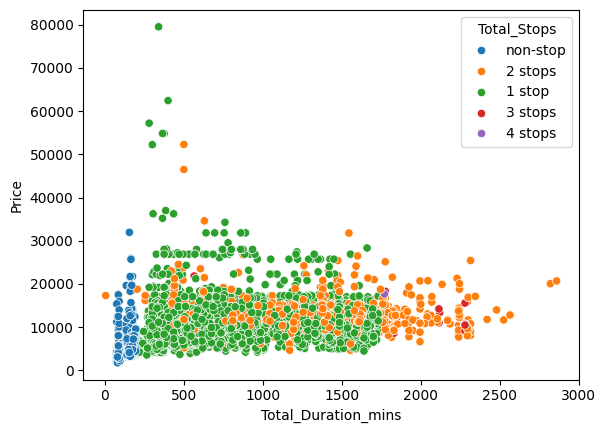

In [28]:
sns.scatterplot(data=df, x='Total_Duration_mins', y='Price', hue='Total_Stops')

In [29]:
# Get the most common route for a specific airline, I'll go with Air India

df[df['Airline']=='Air India'].groupby('Route').size().sort_values(ascending=False)

Route
BLR → DEL                      158
DEL → BOM → COK                117
BOM → HYD                       98
DEL → MAA → COK                 77
DEL → COK                       75
                              ... 
BOM → RPR → VTZ → HYD            1
BOM → JDH → JAI → DEL → HYD      1
BOM → JAI → DEL → HYD            1
BOM → IDR → DEL → HYD            1
BLR → HBX → BOM → NAG → DEL      1
Length: 92, dtype: int64

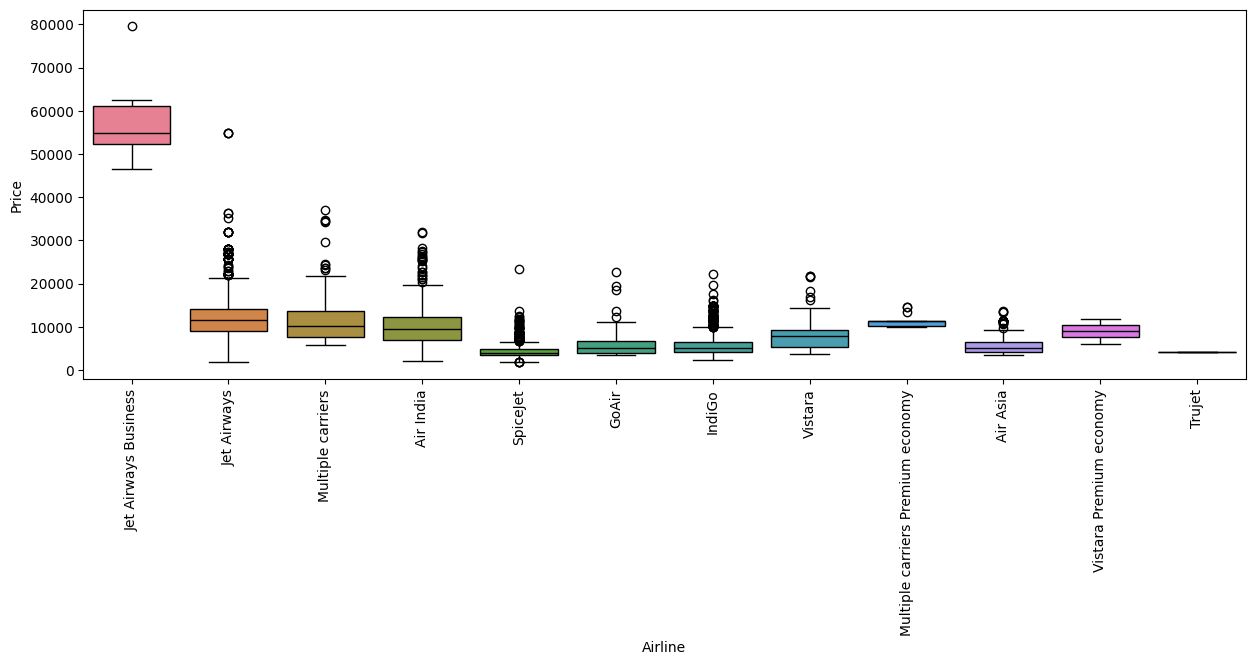

In [30]:
p = sns.boxplot(data=df.sort_values('Price', ascending=False), x='Airline', y='Price', linecolor='black', hue='Airline')
p.figure.set_figwidth(15)
plt.xticks(rotation='vertical')
plt.show()

FEATURE ENGINEERING

In [31]:
cat_col = [col for col in df.columns if df[col].dtype=='object']
num_col = [col for col in df.columns if df[col].dtype!='object']

In [32]:
# One-hot Encoding for Source (less than 10 unique values)

for sub_cat in df['Source'].unique():
    df['Source_'+sub_cat] = df['Source'].apply(lambda x : 1 if x==sub_cat else 0)

In [33]:
# Target guided encoding on Airline

airlines = df.groupby(['Airline'])['Price'].mean().sort_values().index

In [34]:
dict_airlines = {key:index for index, key in enumerate(airlines,0)}

In [35]:
df['Airline'] = df['Airline'].map(dict_airlines)

In [36]:
# Target guided encoding on Destination
# New Delhi and Delhi are the same

df['Destination'].replace('New Delhi', 'Delhi', inplace=True)

In [37]:
dest = df.groupby(['Destination'])['Price'].mean().sort_values().index

In [38]:
dict_dest = {key:index for index, key in enumerate(dest,0)}

In [39]:
df['Destination'] = df['Destination'].map(dict_dest)

In [40]:
# Manual Label encoding on total stops

stops = {'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}

In [41]:
df['Total_Stops'] = df['Total_Stops'].map(stops)

In [42]:
df.columns

Index(['Airline', 'Source', 'Destination', 'Route', 'Total_Stops',
       'Additional_Info', 'Price', 'Journey_Day', 'Journey_Month',
       'Journey_Year', 'Arrival_Time_hour', 'Arrival_Time_minute',
       'Dep_Time_hour', 'Dep_Time_minute', 'Duration_Hours',
       'Duration_Minutes', 'Total_Duration_mins', 'Source_Banglore',
       'Source_Kolkata', 'Source_Delhi', 'Source_Chennai', 'Source_Mumbai'],
      dtype='object')

In [43]:
# Analyse Additional_Info feature

df['Additional_Info'].value_counts()/len(df)*100

Additional_Info
No info                         78.112713
In-flight meal not included     18.554578
No check-in baggage included     2.995694
1 Long layover                   0.177869
Change airports                  0.065531
Business class                   0.037446
No Info                          0.028085
1 Short layover                  0.009362
Red-eye flight                   0.009362
2 Long layover                   0.009362
Name: count, dtype: float64

Since 78% of rows have No info, i'll remove this feature

Route is directly related to the Total_Stops feature thus I'll remove Route feature as well.

In [44]:
cols_to_drop = ['Source', 'Route', 'Additional_Info']

In [45]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [46]:
df.nunique()

Airline                  12
Destination               5
Total_Stops               5
Price                  1870
Journey_Day              10
Journey_Month             4
Journey_Year              1
Arrival_Time_hour        24
Arrival_Time_minute      12
Dep_Time_hour            24
Dep_Time_minute          12
Duration_Hours           44
Duration_Minutes         12
Total_Duration_mins     368
Source_Banglore           2
Source_Kolkata            2
Source_Delhi              2
Source_Chennai            2
Source_Mumbai             2
dtype: int64

In [47]:
# since the feature "Journey_Year" has the same value, we can drop it as well

df.drop(columns='Journey_Year', axis=1, inplace=True)

DEALING WITH OUTLIERS

In [48]:
def calculate_outliers_range(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    
    iqr = q3-q1
    
    min = q1 - 1.5*iqr
    max = q3 + 1.5*iqr
    
    return min, max

In [49]:
def make_plot_outlier(df,col):
    fig, (ax1, ax2) = plt.subplots(2,1)
    
    sns.histplot(df[col],ax=ax1, kde=True)
    sns.boxplot(x=df[col],ax=ax2)

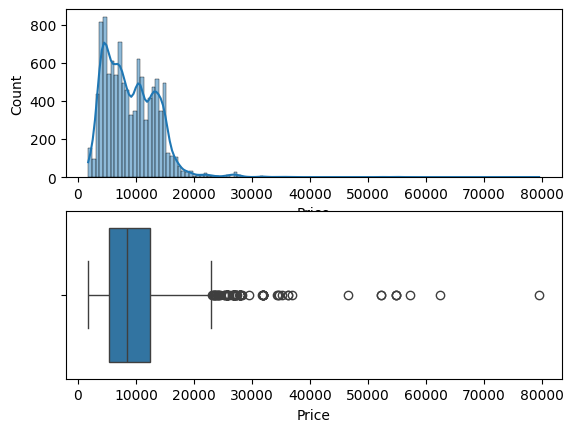

In [50]:
# checking ouliers for price feature
make_plot_outlier(df,'Price')

In [51]:
min,max = calculate_outliers_range(df,'Price')

In [52]:
# we should ask the Domain Knowledge regarding how to handle this outliers
# for now we will remove every value greater than max limit of price

df['Price'] = np.where(df['Price']>=max, df['Price'].median(), df['Price'])

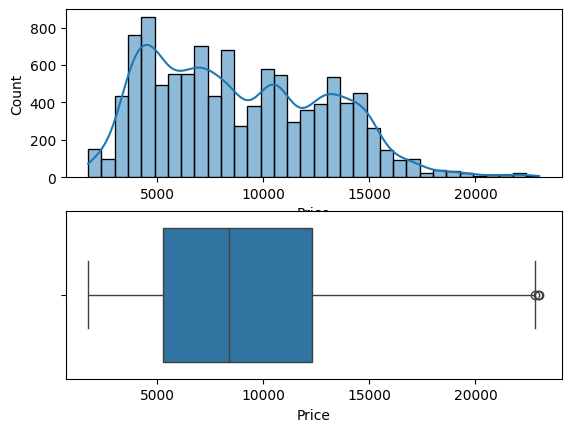

In [53]:
make_plot_outlier(df,'Price')

FEATURE SELECTION

In [54]:
X = df.drop(['Price'],axis=1)
y = df['Price']

In [56]:
reg_info = mutual_info_regression(X,y)

In [65]:
reg_info_df = pd.DataFrame(reg_info,index=X.columns,columns=['Importance'])

In [67]:
reg_info_df.sort_values(by='Importance',ascending=False)

,Importance
Total_Duration_mins,1.777171
Airline,1.314336
Arrival_Time_hour,1.132461
Duration_Hours,1.116311
Destination,1.057361
Dep_Time_hour,0.922301
Arrival_Time_minute,0.896113
Total_Stops,0.777499
Dep_Time_minute,0.754032
Duration_Minutes,0.664365


Since we don't have that many features, and every single one has contribution of their own, we will consider all the features.

MODEL BUILDING

In [69]:
# Split df into test and train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [70]:
from sklearn.ensemble import RandomForestRegressor

In [71]:
# Random Forest
rf_model = RandomForestRegressor()

In [72]:
rf_model.fit(X_train,y_train)

RandomForestRegressor()

In [73]:
y_pred = rf_model.predict(X_test)

In [74]:
from sklearn import metrics

In [79]:
r2 = metrics.r2_score(y_test,y_pred)
print(f'R2 Score of: {round(r2*100,2)}%')

R2 Score of: 79.75%


In [81]:
import pickle

In [84]:
# Dump the model
file = open(r'/Users/jmc/GitHub/PredictAirplaneFare/predict-fares-ariplanes-ticket/models/rf_model.pkl','wb')

In [85]:
pickle.dump(rf_model,file)

Now the model is saved in a file.

To access the model from the file we just add to do the following:

In [86]:
model = open(r'/Users/jmc/GitHub/PredictAirplaneFare/predict-fares-ariplanes-ticket/models/rf_model.pkl','rb')

In [87]:
rf_model2 = pickle.load(model)

In [89]:
y_pred2 = rf_model2.predict(X_test)

In [91]:
r2_2 = metrics.r2_score(y_test,y_pred2)
print(f'R2 Score of: {round(r2_2*100,2)}%')

R2 Score of: 79.75%


Exactly the same R2 score.